In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sqlalchemy import create_engine
from prettytable import PrettyTable


print('=' * 51 + '  Program Description  '+ '=' * 51)
print("This program reads 3 CSV files,"
      "\n-file A training datasets and file B one test dataset, as well as file C datasets for ideal functions."
      "\nAll data respectively consists of x-y-pairs of values-"
      "\nprocesses the data, visulaize it, performs calculations, and stores the results in a SQLite database.")
print('*' * 125)

===================================================  Program Description  ===================================================
This program reads 3 CSV files,
-file A training datasets and file B one test dataset, as well as file C datasets for ideal functions.
All data respectively consists of x-y-pairs of values-
processes the data, visulaize it, performs calculations, and stores the results in a SQLite database.
*****************************************************************************************************************************


In [2]:
while True:
    # Ask the user if the files are ready and in the same directory
    files_ready = input("Are the CSV files ready and in the same directory? (y/n): ").lower()
    
    if files_ready == 'y':
        break
    else:
        print("Please make sure the files are ready and in the current directory.")
        print('*' * 125)
    
# Record the start time
start_time = time.time()  


# Function to read CSV files and handle possible errors while reading
def read_csv_file(file_name): 
    try: 
        # Attempt to read the CSV file
        df = pd.read_csv(file_name)
        return df
    
    except FileNotFoundError:
        # The CSV file does not exist
        print(f"Error: File '{file_name}' not found. Please make sure the file is in the correct location.")
        return None
    
    except pd.errors.EmptyDataError:
        # The CSV file is empty
        print(f"Error: File '{file_name}' is empty.")
        return None
    
    except pd.errors.ParserError:
        # The CSV file is not valid 
        print(f"Error: Unable to parse file '{file_name}'. Make sure it's a valid CSV file.")
        return None

# Loop to repeatedly ask the user for file names until successful read
while True:
    try:
        # Ask the user for file names
        ideal_file = input("Enter the name of the 'Ideal functions' CSV file: ")
        train_file = input("Enter the name of the 'Training Data' CSV file: ")
        test_file = input("Enter the name of the 'Testing Data' CSV file: ")
        print('*' * 125)

        # Attempt to read the CSV files and load them into DataFrames using pandas
        ideal_functions = read_csv_file(ideal_file + '.csv')
        training_data = read_csv_file(train_file + '.csv')
        testing_data = read_csv_file(test_file + '.csv')

        # Make sure that all files are successfully read
        if ideal_functions is not None and training_data is not None and testing_data is not None:
            print('The files are successfully read!')
        else:
            print('Unable to read the files')
            print('*' * 125)
            continue

        # Validating the files
        if 'x' not in ideal_functions.columns or 'x' not in training_data.columns:
            print("Error: Both 'ideal' and 'train' files must have a column named 'x'.")
            print('*' * 125)
            continue

        if 'x' not in testing_data.columns or not set(testing_data['x']).issubset(set(ideal_functions['x'])):
            print("Error: The 'test' file must have a column named 'x' and its values must be part of 'ideal' or 'train'.")
            print('*' * 125)
            continue

        if not ideal_functions['x'].equals(training_data['x']):
            print("Error: The 'x' values in 'ideal' and 'train' files must be the same.")
            print('*' * 125)
            continue

        # Break the loop if all files are successfully read and validated
        print("The Files are validated successfully!")
        ideal_func_list = list(ideal_functions.columns[1:])
        training_func_list = list(training_data.columns[1:])
        print('*' * 125)
        print(f"Ideal Functions are {len(ideal_func_list)} functions which are:\n {ideal_func_list}")
        print('*' * 125)
        print(f"Training Data is {len(training_func_list)} functions which are:\n {training_func_list}")
        print('*' * 125)
        break

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        print('*' * 125)

Are the CSV files ready and in the same directory? (y/n): y
Enter the name of the 'Ideal functions' CSV file: ideal
Enter the name of the 'Training Data' CSV file: train
Enter the name of the 'Testing Data' CSV file: test
*****************************************************************************************************************************
The files are successfully read!
The Files are validated successfully!
*****************************************************************************************************************************
Ideal Functions are 50 functions which are:
 ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17', 'y18', 'y19', 'y20', 'y21', 'y22', 'y23', 'y24', 'y25', 'y26', 'y27', 'y28', 'y29', 'y30', 'y31', 'y32', 'y33', 'y34', 'y35', 'y36', 'y37', 'y38', 'y39', 'y40', 'y41', 'y42', 'y43', 'y44', 'y45', 'y46', 'y47', 'y48', 'y49', 'y50']
********************************************************************

In [3]:
# Function to rename columns of a DataFrame with a specified type to loaded in the database!
def rename_dataframe(df, df_type):
    column_mapping = {}
    for column in df.columns:
        new_column_name = column.upper() + ' (' + df_type + ')'
        column_mapping[column] = new_column_name
    return column_mapping

# Function to adjust the reuslt of quering for the database to be displayed in PrettyTables
def slice_list(l):
    sliced_list = l[:4]
    sliced_list.extend(['----------'])
    sliced_list.append(l[-1])
    return sliced_list

# Connecting to a database & Loading Ideal & Trainig tables & Displaying Snapshot of both tables
try:
    # Create a SQLite database engine
    engine = create_engine('sqlite:///mydatabase.db')

    # Connect to the database engine
    with engine.connect() as connection:
        # Rename and replace then add the tables in the database
        ideal_functions.rename(columns=rename_dataframe(ideal_functions, 'ideal func')).to_sql('The ideal functions', engine, index=False, if_exists='replace', index_label='column_name')
        training_data.rename(columns=rename_dataframe(training_data, 'training func')).to_sql('The training data', engine, index=False, if_exists='replace', index_label='column_name')
        
        # Execute a query to retrieve and display the first 5 rows of both tables
        check_ideal_table = engine.execute("SELECT * FROM 'The ideal functions' LIMIT 5")
        check_train_table = engine.execute("SELECT * FROM 'The training data' LIMIT 5")
        
        # Create PrettyTables to display the result sets in a tabular format
        columns1 = check_ideal_table.keys()
        columns2 = check_train_table.keys()
                
        table1 = PrettyTable(slice_list(list(columns1)))
        for row in check_ideal_table.fetchall():
            table1.add_row(slice_list(list(row)))
          
        table2 = PrettyTable(columns2)
        for row in check_train_table.fetchall(): 
            table2.add_row(row)
        
        print('=' * 39 + '  Ideal Functions Snapshot From the Data Base  '+ '=' * 39)
        print(table1)
        print('*' * 125)
        print('=' * 40 + '  Training Data Snapshot From the Data Base  '+ '=' * 40)
        print(table2)
        print('*' * 125)

except Exception as e:
    # Handle any exceptions that might occur during the database connection
    print(f"An error occurred while connecting to the database: {e}")
    print('*' * 125)

=======================================  Ideal Functions Snapshot From the Data Base  =======================================
+----------------+-----------------+-----------------+-----------------+------------+------------------+
| X (ideal func) | Y1 (ideal func) | Y2 (ideal func) | Y3 (ideal func) | ---------- | Y50 (ideal func) |
+----------------+-----------------+-----------------+-----------------+------------+------------------+
|     -20.0      |    -0.9129453   |    0.40808207   |     9.087055    | ---------- |    0.3968496     |
|     -19.9      |    -0.8676441   |    0.4971858    |     9.132356    | ---------- |    0.47695395    |
|     -19.8      |   -0.81367373   |    0.58132184   |     9.186326    | ---------- |    0.5491291     |
|     -19.7      |   -0.75157344   |    0.65964943   |     9.248426    | ---------- |    0.6128399     |
|     -19.6      |    -0.6819636   |    0.7313861    |     9.318036    | ---------- |    0.6679019     |
+----------------+----------------

In [4]:
# Function to visualize dataFrames appropriately in a layout
def visualize_data_table(df,nr,nc,df_name):
    # Create a table of figures with 17 rows and 3 columns
    num_rows = nr
    num_cols = nc
    num_subplots = num_rows * num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(nc*10, nr*8))  # Adjust the figsize as needed

    # Create subplots for ideal functions
    for i, column in enumerate(df.columns[1:]):
        ax = axes[i // num_cols, i % num_cols]
        ax.plot(df['x'], df[column], label=f"{df_name.split(' ')[0]}: {column.upper()}")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'{df_name}: {column.upper()}', fontsize= nc*15)
        ax.legend(loc='best')

    # Hide any remaining empty subplots
    for i in range(len(df.columns) - 1, num_subplots):
        fig.delaxes(axes[i // num_cols, i % num_cols])

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the table of figures
    plt.show()

==============================================  Ideal Functions Visualization  ==============================================


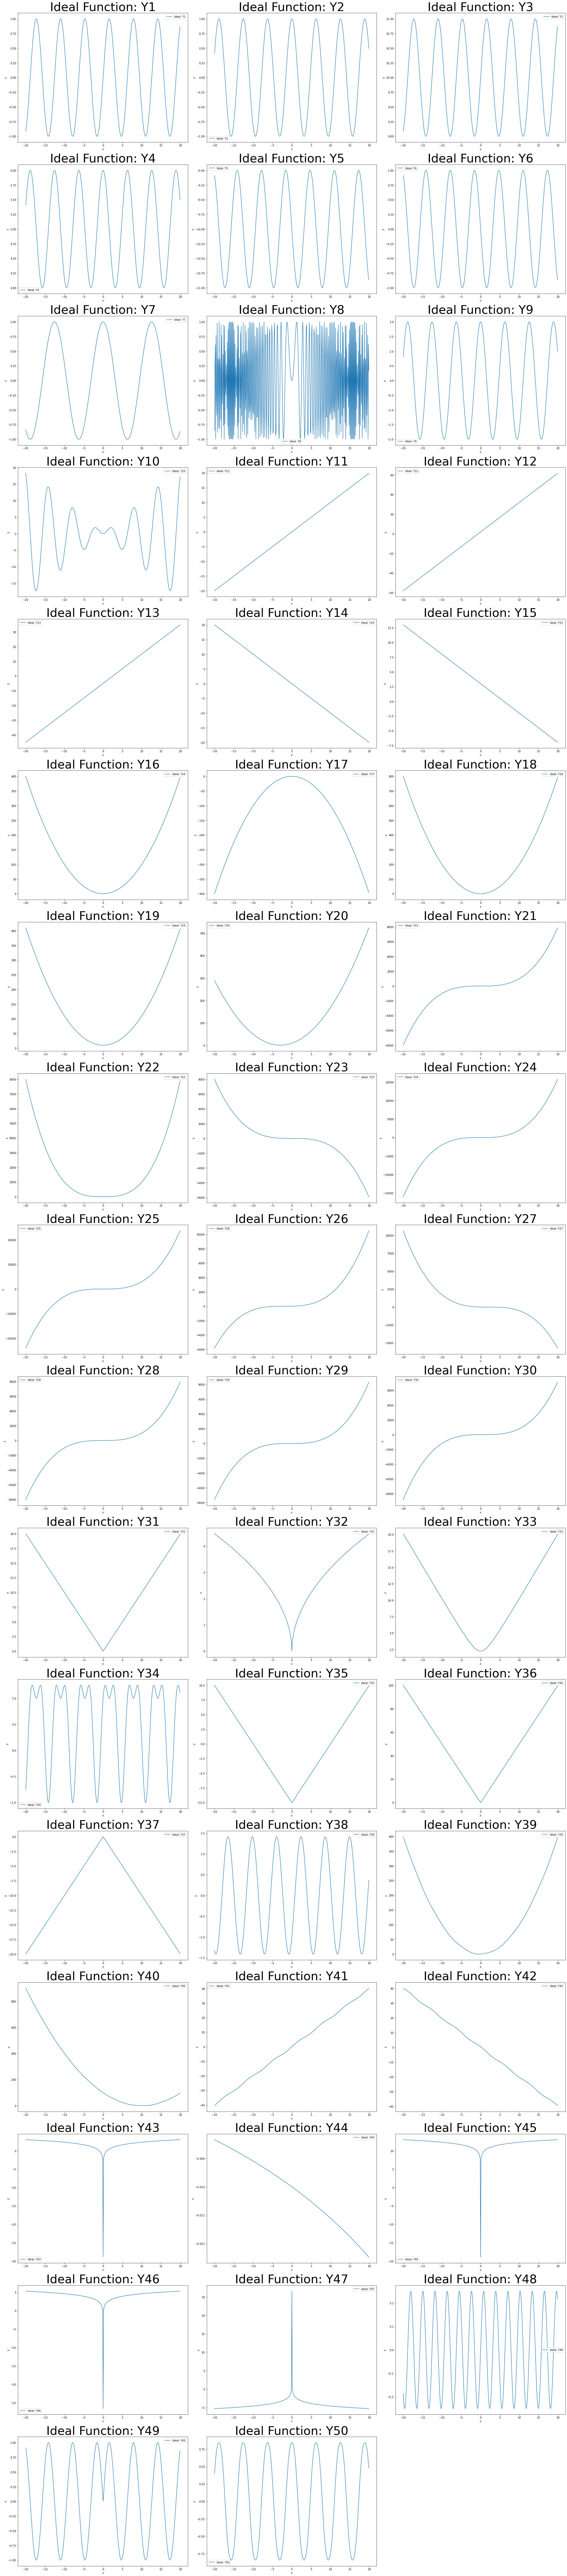

*****************************************************************************************************************************
============================================  Training Functions Visualization  =============================================


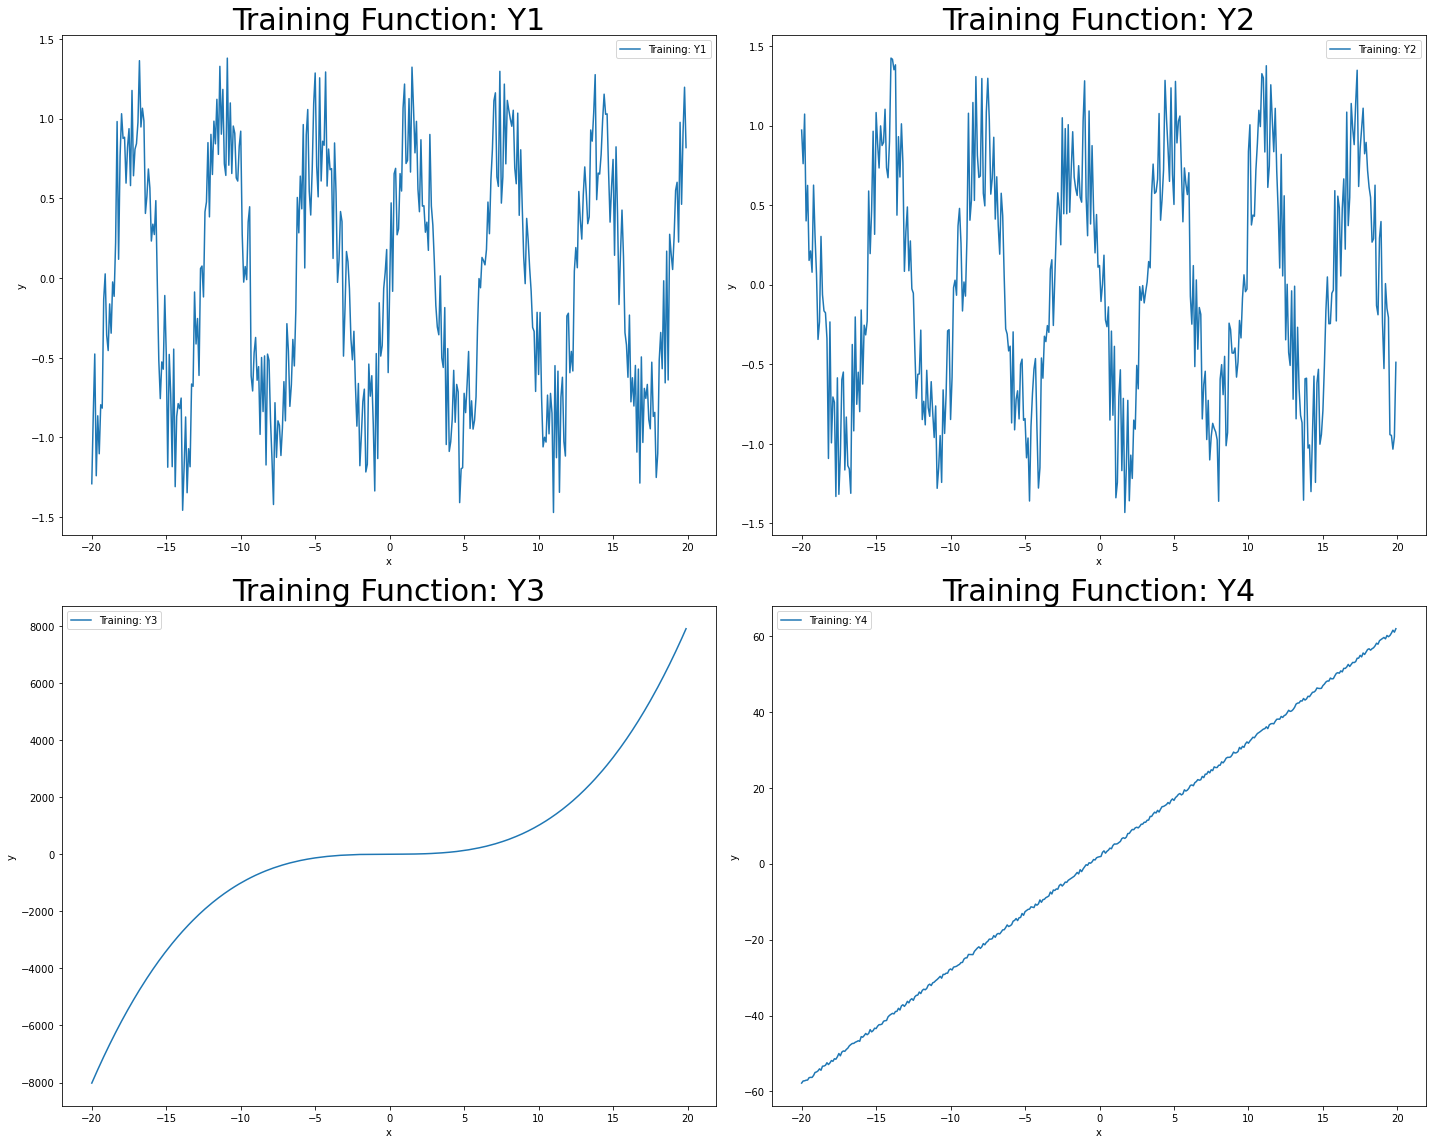

*****************************************************************************************************************************


In [5]:
# Vislualize Choosen Ideal Functions & Training Functions    
print('=' * 46 + '  Ideal Functions Visualization  '+ '=' * 46)
visualize_data_table(ideal_functions,17,3,'Ideal Function')
print('*' * 125)
print('=' * 44 + '  Training Functions Visualization  '+ '=' * 45)
visualize_data_table(training_data,2,2,'Training Function')
print('*' * 125)

In [6]:
# Calculating Square Root Errors & Find the Choosen Ideal Functions        
def calculate_total_cost(ideal_functions, training_data, training_func):
    """
    Calculates the total cost for each ideal function against a training function.

    Parameters:
    - ideal_functions (DataFrame): DataFrame containing ideal functions data.
    - training_data (DataFrame): DataFrame containing training data.
    - training_func (str): The specific training function to compare with.

    Returns:
    - DataFrame: A DataFrame with Ideal_function and corresponding Error sorted by Error.
    """
    cost_all = []
    # Iterate over each ideal function
    for ideal_function in ideal_functions.columns[1:]:
        total_cost = 0
        i = 0
        # Calculate cost for each value in the ideal function
        for value in ideal_functions[ideal_function]:
            cost = (value - training_data.at[i, training_func]) ** 2
            total_cost += cost
            i += 1
        # Calculate the average cost
        total_cost /= i
        cost_all.append([ideal_function, total_cost])
    
    # Create a DataFrame with Ideal_function and corresponding Error
    df = pd.DataFrame(cost_all, columns=['Ideal_function', 'Error'])
    df.sort_values(by='Error', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Initialize an empty DataFrame to store chosen ideal functions for forming the collective DataFrame later to deviation calculations
choosen_ideal_functions = pd.DataFrame()
choosen_ideal_functions['x'] = ideal_functions['x']
choosen_ideal_func_list = []

# Iterate over each training functions for cost calculation
for training_function in training_func_list:
    # Calculate the total cost and choose the top ideal function
    df = calculate_total_cost(ideal_functions, training_data, training_function)
    
    # Add the chosen ideal function and corresponding training function to the DataFrame 
    choosen_ideal_functions[df.iloc[0,0].upper() + ' (ideal func)'] = ideal_functions[df.iloc[0,0]]
    choosen_ideal_functions[training_function.upper() + ' (train func)'] = training_data[training_function]
    # list of tuples for the names of choosen ideal function and corresponding training function
    choosen_ideal_func_list.append((df.iloc[0,0],training_function))

================================  Choosen Ideal Function VS Corresponding Training Function  ================================
+------------------------+---------------------------------+
| Choosen Ideal Function | Corresponding Training Function |
+------------------------+---------------------------------+
|           y1           |                y1               |
|           y6           |                y2               |
|          y28           |                y3               |
|          y12           |                y4               |
+------------------------+---------------------------------+
*****************************************************************************************************************************
=========================  Choosen Ideal Function VS Corresponding Training Function Visualization  =========================


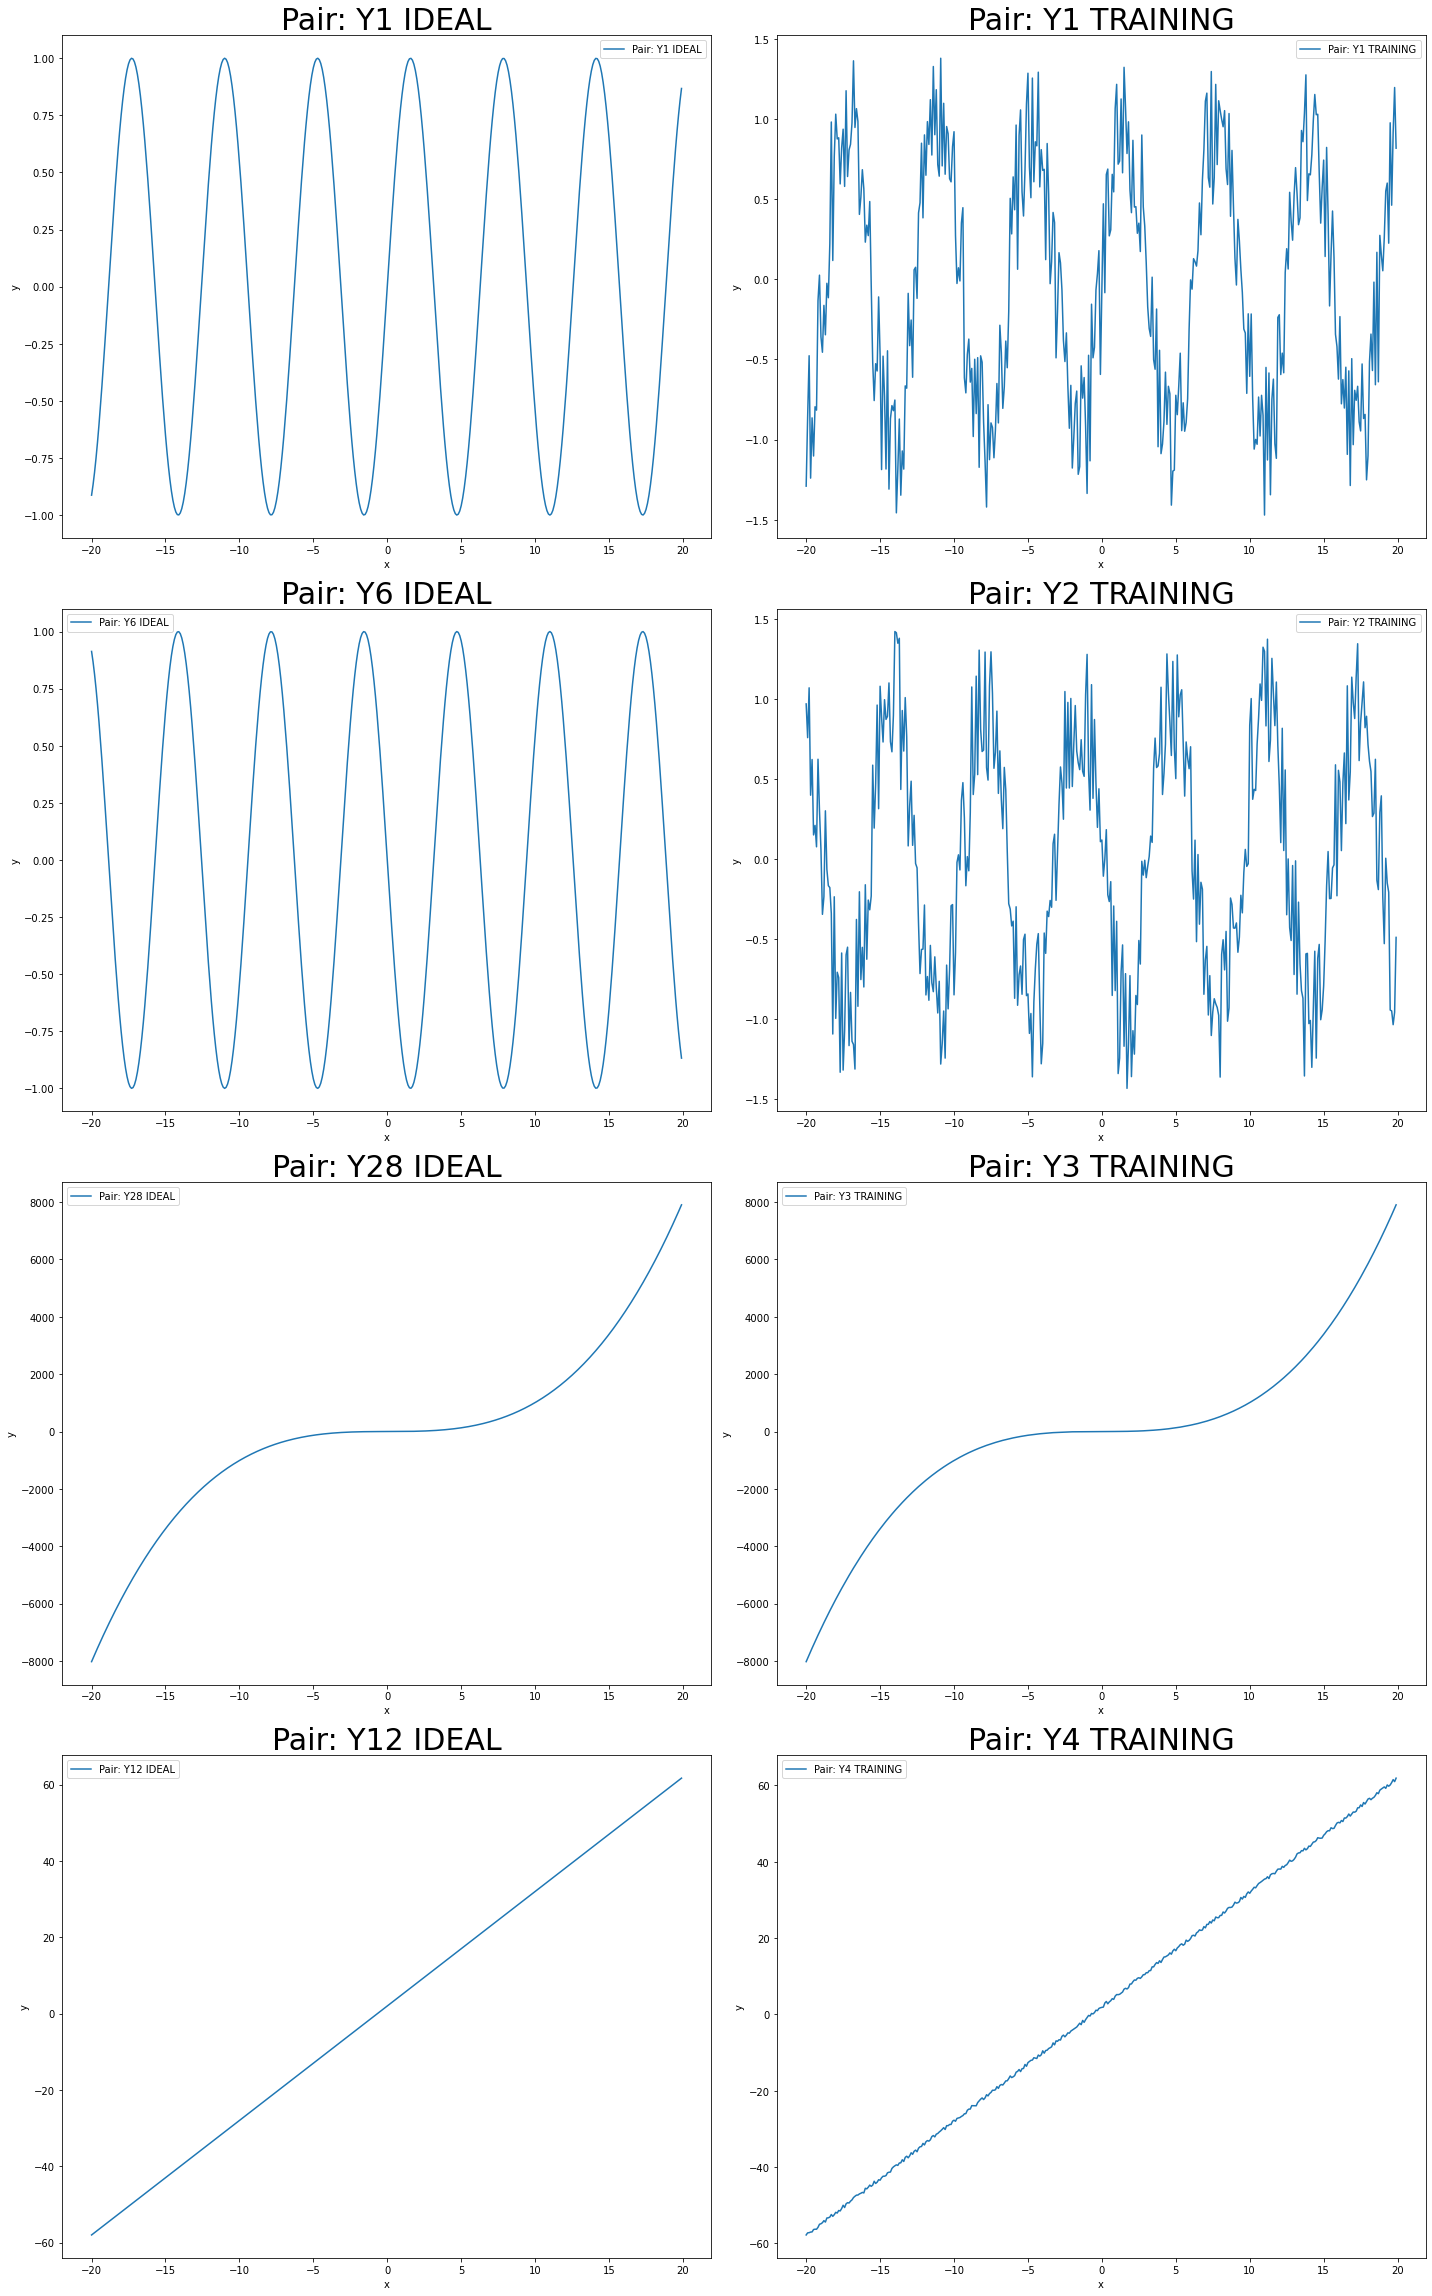

*****************************************************************************************************************************


In [7]:
# Create a PrettyTable to show the Choosen Ideal Functions and their corresponding training functions
table = PrettyTable(['Choosen Ideal Function', 'Corresponding Training Function'])
for row in choosen_ideal_func_list:
    table.add_row(row)
print('=' * 32 + '  Choosen Ideal Function VS Corresponding Training Function  '+ '=' * 32)
print(table)
print('*' * 125)

# Vislualize Choosen Ideal Function VS Corresponding Training Function in pairs
pair = pd.DataFrame()
pair['x'] = ideal_functions['x']
for i,t in choosen_ideal_func_list: 
    pair[i + ' Ideal'] = ideal_functions[i]
    pair[t + ' Training'] = training_data[t]
print('=' * 25 + '  Choosen Ideal Function VS Corresponding Training Function Visualization  '+ '=' * 25)
visualize_data_table(pair,4,2,'Pair')
print('*' * 125)

In [8]:
# Map the Testing Data and Match it to the choosen Ideal Functions

# Create a Mapped Data DataFrame from testing data & Add 2 extra columns for the deviation & matched ideal function
mapped_data = testing_data.rename(columns={'x': 'X (test func)', 'y': 'Y (test func)'})
mapped_data.insert(loc=mapped_data.columns.get_loc('Y (test func)') + 1, column='Delta Y (test func)', value= 0)
mapped_data.insert(loc=mapped_data.columns.get_loc('Y (test func)') + 2, column='No. of ideal func', value= '---')

# Displaying a Snapshot of Mapped Data Before the mapping & matching process
m_before_table = PrettyTable(list(mapped_data.columns))

# Add the first 5 rows to the PrettyTable
for _, row in mapped_data.head().iterrows():
    m_before_table.add_row(row.tolist())

print('=' * 46 + '  Mapped Data Snapshot Before!!  '+ '=' * 46)
print(m_before_table)
print('*' * 125)


# Create Collective DataFrame by merging the chosen ideal functions and corresponding training function with testing data to calcualte the deviation!
collective_functions = testing_data.merge(choosen_ideal_functions, on='x', how='left').rename(columns={'x': 'X (test func)', 'y': 'Y (test func)'})

threshold_factor = np.sqrt(2)
rows_to_drop = []  # List to store indices of rows to be dropped

first_matched = 0 # counter for how many functions matched to first choosen ideal function -here is y1-  
second_matched = 0 # counter for how many functions matched to second choosen ideal function -here is y6-
third_matched = 0 # counter for how many functions matched to third choosen ideal function -here is y28-
fourth_matched = 0 # counter for how many functions matched to fourth choosen ideal function -here is y12-
# The counters here are functions name independent

# Iterate over rows of the Mapped Data DataFrame to calculate the deviation 
for index, row in mapped_data.iterrows():
    # Calculate the deviation between the test function and each ideal function
    deviation_bet_test_ideal = [
        np.abs(row['Y (test func)'] - collective_functions.iloc[index, 2]),
        np.abs(row['Y (test func)'] - collective_functions.iloc[index, 4]),
        np.abs(row['Y (test func)'] - collective_functions.iloc[index, 6]),
        np.abs(row['Y (test func)'] - collective_functions.iloc[index, 8])
    ]
    # The indices here are functions name independent 
    # col index 2 => Y1 (ideal func), col index 3 => Y1 (train func)
    # col index 4 => Y6 (ideal func), col index 5 => Y2 (train func)
    # col index 6 => Y28 (ideal func), col index 7 => Y3 (train func)
    # col index 8 => Y12 (ideal func), col index 9 => Y4 (train func)
    
    # Update the 'Delta Y (test func)' column with the maximum deviation
    mapped_data.at[index, 'Delta Y (test func)'] = max(deviation_bet_test_ideal)
    
    # Get the index of the maximum deviation
    max_index = deviation_bet_test_ideal.index(max(deviation_bet_test_ideal))
    
    # Check conditions for setting the value of 'No. of ideal func' OR store indices of rows to be dropped
    if max_index == 0:
        if max(deviation_bet_test_ideal) <= threshold_factor * np.abs(
                collective_functions.iloc[index, 2] - collective_functions.iloc[index, 3]):
            mapped_data.at[index, 'No. of ideal func'] = str(choosen_ideal_func_list[0][0]).upper()
            first_matched += 1          
        else:
            rows_to_drop.append(index)
            mapped_data.at[index, 'No. of ideal func'] = 'NOT Matched'
    
    elif max_index == 1:
        if max(deviation_bet_test_ideal) <= threshold_factor * np.abs(
                collective_functions.iloc[index, 4] - collective_functions.iloc[index, 5]):
            mapped_data.at[index, 'No. of ideal func'] = str(choosen_ideal_func_list[1][0]).upper()
            second_matched += 1      
        else:
            rows_to_drop.append(index)
            mapped_data.at[index, 'No. of ideal func'] = 'NOT Matched'
    
    elif max_index == 2:
        if max(deviation_bet_test_ideal) <= threshold_factor * np.abs(
                collective_functions.iloc[index, 6] - collective_functions.iloc[index, 7]):
            mapped_data.at[index, 'No. of ideal func'] = str(choosen_ideal_func_list[2][0]).upper()
            third_matched += 1
        else:
            rows_to_drop.append(index)
            mapped_data.at[index, 'No. of ideal func'] = 'NOT Matched'
    
    elif max_index == 3:
        if max(deviation_bet_test_ideal) <= threshold_factor * np.abs(
                collective_functions.iloc[index, 8] - collective_functions.iloc[index, 9]):
            mapped_data.at[index, 'No. of ideal func'] = str(choosen_ideal_func_list[3][0]).upper()
            fourth_matched += 1
        else:
            rows_to_drop.append(index)
            mapped_data.at[index, 'No. of ideal func'] = 'NOT Matched'
    

# Displaying a Snapshot of Mapped Data after the mapping & matching process
m_after_table = PrettyTable(list(mapped_data.columns))

# Add the first 5 rows to the PrettyTable
for _, row in mapped_data.head().iterrows():
    m_after_table.add_row(row.tolist())

print('=' * 46 + '  Mapped Data Snapshot after!!!  '+ '=' * 46)
print(m_after_table)
print('*' * 125)

matched_mapped_data = mapped_data.copy()  # Create a copy of Mapped Data to show the matched Functions
matched_mapped_data.drop(rows_to_drop, inplace=True)  # Drop the specified rows in-place
matched_mapped_data.reset_index(drop=True, inplace=True)  # Reset the index

# Displaying a Snapshot of Matched Mapped Data after the mapping & matching process
m_m_table = PrettyTable(list(matched_mapped_data.columns))

# Add the first 5 rows to the PrettyTable
for _, row in matched_mapped_data.head().iterrows():
    m_m_table.add_row(row.tolist())

print('=' * 46 + '  Matched Mapped Data Snapshot!  '+ '=' * 46)
print(m_m_table)
print(f"1- Number of Points Matched to Choosen Ideal Function {str(choosen_ideal_func_list[0][0]).upper()}: {first_matched}")
print(f"2- Number of Points Matched to Choosen Ideal Function {str(choosen_ideal_func_list[1][0]).upper()}: {second_matched}")
print(f"3- Number of Points Matched to Choosen Ideal Function {str(choosen_ideal_func_list[2][0]).upper()}: {third_matched}")
print(f"4- Number of Points Matched to Choosen Ideal Function {str(choosen_ideal_func_list[3][0]).upper()}: {fourth_matched}")
print(f"5- Number of Points Not Matched to any Choosen Ideal Function: {len(rows_to_drop)}")
print('*' * 125)

==============================================  Mapped Data Snapshot Before!!  ==============================================
+---------------+---------------+---------------------+-------------------+
| X (test func) | Y (test func) | Delta Y (test func) | No. of ideal func |
+---------------+---------------+---------------------+-------------------+
|      -4.0     |   1.0441712   |          0          |        ---        |
|      19.6     |   5240.1787   |          0          |        ---        |
|      -7.2     |   2.0632932   |          0          |        ---        |
|     -14.6     |   -43.10617   |          0          |        ---        |
|     -17.4     |   -1.2171963  |          0          |        ---        |
+---------------+---------------+---------------------+-------------------+
*****************************************************************************************************************************
==============================================  Mapped Data Snap

In [9]:
#Connect to the DataBase Add the Mapped Data table in the database
try:
    # Create a SQLite database engine
    engine = create_engine('sqlite:///mydatabase.db')

    # Connect to the database engine
    with engine.connect() as connection:
        # Add the tables in the database
        mapped_data.to_sql('The mapped data', engine, index=False, if_exists='replace', index_label='column_name')
        
        # Execute a query to retrieve and display the first 5 rows of the table
        check_mappedData_table = engine.execute("SELECT * FROM 'The mapped data' LIMIT 5")
        
        # Create PrettyTables to display the result sets in a tabular format
        columns3 = check_mappedData_table.keys()
        table3 = PrettyTable(columns3)
        for row in check_mappedData_table.fetchall():
            table3.add_row(row)  
        print('=' * 40 + '  Mapped Data Snapshot From the Data Base!!  '+ '=' * 40)
        print(table3)
        print('*' * 125)

except Exception as e:
    # Handle any exceptions that might occur during the database connection
    print(f"An error occurred while connecting to the database: {e}")
    print('*' * 125)

========================================  Mapped Data Snapshot From the Data Base!!  ========================================
+---------------+---------------+---------------------+-------------------+
| X (test func) | Y (test func) | Delta Y (test func) | No. of ideal func |
+---------------+---------------+---------------------+-------------------+
|      -4.0     |   1.0441712   |      69.0441712     |    NOT Matched    |
|      19.6     |   5240.1787   |     5240.8606636    |    NOT Matched    |
|      -7.2     |   2.0632932   |  382.51129319999995 |    NOT Matched    |
|     -14.6     |   -43.10617   |      3083.62983     |    NOT Matched    |
|     -17.4     |   -1.2171963  |     5284.2068037    |    NOT Matched    |
+---------------+---------------+---------------------+-------------------+
*****************************************************************************************************************************


In [10]:
# Record the end time
end_time = time.time()

# Print the elapsed time
elapsed_time = end_time - start_time
print(f"Code execution time: {elapsed_time:.2f} seconds")


# Check if there are three tables in the database
engine = create_engine('sqlite:///mydatabase.db')
with engine.connect() as connection:
    result = connection.execute("SELECT name FROM sqlite_master WHERE type='table';")
    table_names = result.fetchall()
        
    if len(table_names) == 3:
        print("Success: Expected three tables in the database.")
    else:
        print(f"Failure: Expected three tables, but found {len(table_names)} tables.")
        for name in table_names:
            print(f"Found table: {name}")

Code execution time: 27.20 seconds
Success: Expected three tables in the database.
